## Implementation of an simple Autoencoder FANN

Dataset:

* MNIST
* 28x28 grayscale images of handwritten digits (0–9)
* test dataset: 10.000 images
* training dataset 60.000 images

Goal:

* Build and implement a simple Autoencoder FANN
* Classification and reconstruction of images of handwritten digits (0–9)

In [ ]:
#Mount personal Google Drive to colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/UU/AI_for_IA/Autoencoders')

Mounted at /content/drive


In [ ]:
#Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors
from torch.utils.data import random_split

In [ ]:
#Set the parameters
random_seed = 49
learning_rate = 0.0005
num_epochs = 30
batch_size = 256
num_classes = 10

#Download MNIST dataset
def get_mnist(batch_size, num_workers=0, train_transforms=None, test_transforms=None):

  #Set the type of transformers if not defined to tensor
  if train_transforms == None:
    train_transforms = transforms.ToTensor()
  if test_transforms == None:
    test_transforms = transforms.ToTensor()

  #Download data
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
  #valid_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=test_transforms)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

  train_size = int(0.8 * len(train_dataset))  # 80% for training
  valid_size = len(train_dataset) - train_size  # 20% for validation

  train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

  #Create dataloader
  train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
  valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = len(valid_dataset), shuffle = False, num_workers = num_workers)
  test_dataloader = DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = False, num_workers = num_workers)

  return train_dataloader, valid_dataloader, test_dataloader

train_loader, valid_loader, test_loader = get_mnist(batch_size)

Training Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([0, 7, 6, 4, 9, 7, 8, 9, 6, 6])

Test Set:
Image batch dimensions: torch.Size([10000, 1, 28, 28])
Image label dimensions: torch.Size([10000])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

Validation Set:
Image batch dimensions: torch.Size([12000, 1, 28, 28])
Image label dimensions: torch.Size([12000])
tensor([7, 6, 6, 3, 1, 2, 0, 0, 4, 8])

Images range of data:
tensor(0.) tensor(1.)

Images of the train dataset:


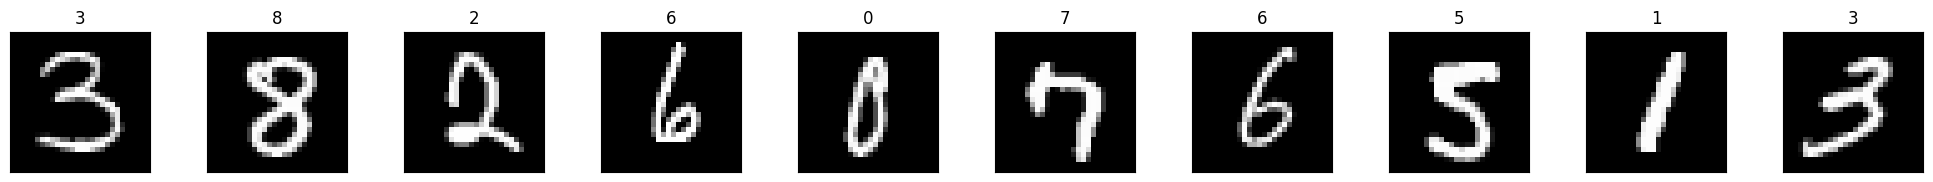

In [ ]:
#Check datasets

print('Training Set:')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

print('\nTest Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

images, labels = next(iter(train_loader))
print("\nImages range of data:")
print(torch.min(images), torch.max(images))

#Plot a few images of the train dataset
def plot_images(images):
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(10):
      ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title(labels[idx].item())

print("\nImages of the train dataset:")
plot_images(images) #images are extracted from the iter above

# Model described in the paper

In [ ]:
#Define the class model autoencoder

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class Autoencoder(nn.Module):

  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding = 1),
        nn.Flatten(),
        nn.Linear(3136, 2)
    )

    self.decoder = nn.Sequential(
        torch.nn.Linear(2, 3136),
        Reshape(-1, 64, 7, 7), #alternatice  nn.Unflatten(1, (64, 7, 7)),
        nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size= (3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size= (3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size= (3, 3), padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32, 1, stride=(2, 2), kernel_size= (3, 3), padding=0),
        Trim(), #alternative with pytorch nn.CenterCrop((28, 28)),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):

  total_loss = 0.0
  num_batches = len(data_loader)

    #Loop through each batch in the data loader
  for features, _ in data_loader:

    logits = model(features)
    batch_loss = loss_fn(logits, features)
    total_loss += batch_loss.item()

    #Calculate the average loss across all batches in the epoch
  epoch_loss = total_loss / num_batches
  return epoch_loss

In [ ]:
#Training of the autoencoder

def train_autoencoder(num_epochs, model, optimizer,
                         train_loader, loss_fn=None,
                         logging_interval=50,
                         skip_epoch_stats=None,
                         save_model=None):

  log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}
  if loss_fn is None:
    loss_fn = F.mse_loss #Default to MSE loss if not provided

  start_time = time.time()

  for epoch in range(num_epochs):
    model.train()

    for batch_idx, (features, _) in enumerate(train_loader):
      #FORWARD AND BACK PROPAGATION
      logits = model(features)
      loss = loss_fn(logits, features)
      optimizer.zero_grad()
      loss.backward()
      # UPDATE MODEL PARAMETERS
      optimizer.step()

      #LOGGING
      log_dict['train_loss_per_batch'].append(loss.item())
      if not batch_idx % logging_interval:
        print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
        % (epoch+1, num_epochs, batch_idx,
            len(train_loader), loss))

    #EPOCH-LEVEL STATISTICS (optional)
    if not skip_epoch_stats:
      model.eval()
      with torch.set_grad_enabled(False):  # Save memory during inference
          train_loss = compute_epoch_loss_autoencoder(model, train_loader, loss_fn)
          print('***Epoch: %03d/%03d | Loss: %.3f' % (epoch+1, num_epochs, train_loss))
          log_dict['train_loss_per_epoch'].append(train_loss)
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  #SAVE MODEL (optional)
  if save_model is not None:
    torch.save(model.state_dict(), save_model) # Save model weights
  return log_dict


model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

#train_loader, valid_loader, test_loader = get_mnist(batch_size)

autoencoder_log_dict = train_autoencoder(num_epochs, model, optimizer, train_loader, loss_fn, save_model="./autoencoder_weights.pth")

#Save log
np.save('./autoencoder_log_dict.npy', autoencoder_log_dict)

Epoch: 001/030 | Batch 0000/0188 | Loss: 0.2623
Epoch: 001/030 | Batch 0050/0188 | Loss: 0.1095
Epoch: 001/030 | Batch 0100/0188 | Loss: 0.0936
Epoch: 001/030 | Batch 0150/0188 | Loss: 0.0924
***Epoch: 001/030 | Loss: 0.070
Time elapsed: 5.32 min
Epoch: 002/030 | Batch 0000/0188 | Loss: 0.0699
Epoch: 002/030 | Batch 0050/0188 | Loss: 0.0651
Epoch: 002/030 | Batch 0100/0188 | Loss: 0.0621
Epoch: 002/030 | Batch 0150/0188 | Loss: 0.0598
***Epoch: 002/030 | Loss: 0.058
Time elapsed: 9.51 min
Epoch: 003/030 | Batch 0000/0188 | Loss: 0.0580
Epoch: 003/030 | Batch 0050/0188 | Loss: 0.0561
Epoch: 003/030 | Batch 0100/0188 | Loss: 0.0547
Epoch: 003/030 | Batch 0150/0188 | Loss: 0.0546
***Epoch: 003/030 | Loss: 0.054
Time elapsed: 13.83 min
Epoch: 004/030 | Batch 0000/0188 | Loss: 0.0521
Epoch: 004/030 | Batch 0050/0188 | Loss: 0.0530
Epoch: 004/030 | Batch 0100/0188 | Loss: 0.0513
Epoch: 004/030 | Batch 0150/0188 | Loss: 0.0521
***Epoch: 004/030 | Loss: 0.051
Time elapsed: 18.15 min
Epoch: 005

In [ ]:
#Load model
model = Autoencoder()
model.load_state_dict(torch.load("./autoencoder_weights.pth"))
model.eval()

#Load logs
autoencoder_log_dict = np.load('autoencoder_log_dict.npy', allow_pickle=True).item()

<ipython-input-36-f66239c1d806>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./autoencoder_weights.pth"))


In [ ]:
from torchsummary import summary
import torchsummary

#Fetch summary of the model
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
           Flatten-8                 [-1, 3136]               0
            Linear-9                    [-1, 2]           6,274
           Linear-10                 [-1, 3136]           9,408
          Reshape-11             [-1, 64, 7, 7]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

In [ ]:
#Evaluation of the model on the test set
def evaluate_autoencoder(model, data_loader, loss_fn):
  model.eval()
  total_loss = 0.0
  num_batches = len(data_loader)

  #Loop through each batch in the data loader
  for features, _ in data_loader:
    logits = model(features)
    batch_loss = loss_fn(logits, features)
    total_loss += batch_loss.item()

  #Calculate the average loss across all batches in the epoch
  epoch_loss = total_loss / num_batches
  return epoch_loss


loss_fn = nn.MSELoss()
test_loss = evaluate_autoencoder(model, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0414


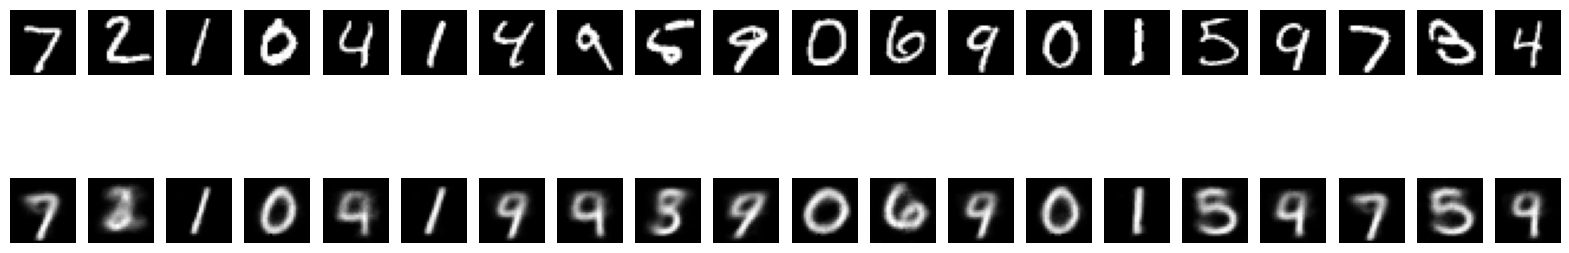

In [ ]:
#Reconstruction of images on test set
def plot_reconstruction(model, data_loader, num_samples=20):
  model.eval()
  with torch.no_grad():
    for i, (images, _) in enumerate(data_loader):
      if i >= num_samples:
        break
        # Forward pass
      reconstructed = model(images)

      # Plot the original and reconstructed images
      fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
      for j in range(num_samples):
        axes[0, j].imshow(images[j].squeeze(), cmap='gray')
        axes[0, j].axis('off')
        axes[1, j].imshow(reconstructed[j].squeeze(), cmap='gray')
        axes[1, j].axis('off')
      plt.show()

plot_reconstruction(model, test_loader, 20)

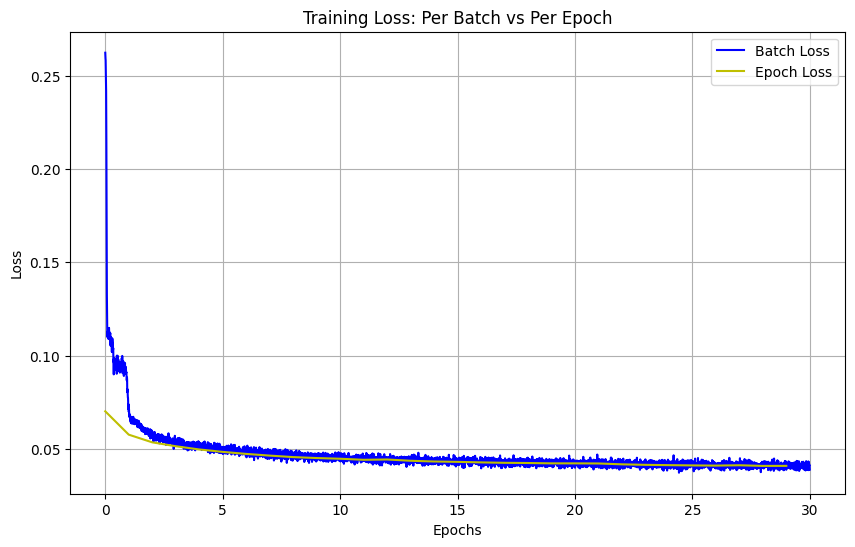

In [ ]:
#Plot the errors
train_loss_per_epoch = autoencoder_log_dict['train_loss_per_epoch']
train_loss_per_batch = autoencoder_log_dict['train_loss_per_batch']

#Number of batches per epoch
num_batches_per_epoch = 235
num_epochs = len(train_loss_per_epoch)

#Create x-axis for batch and epoch losses
x_batch = np.linspace(0, num_epochs, len(train_loss_per_batch))

#Create x-axis for epoch losses
x_epoch = np.arange(0, num_epochs)

#Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(x_batch, train_loss_per_batch, c='b', label='Batch Loss')
plt.plot(x_epoch, train_loss_per_epoch, c='y', label='Epoch Loss',)
plt.title('Training Loss: Per Batch vs Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Extracting the latent space

def extract_latent_space(model, data_loader):
  model.eval()
  latent_space = []
  with torch.no_grad():
    for features, _ in data_loader:
      latent_space.append(model.encoder(features))
  return torch.cat(latent_space, dim=0)

latent_space = extract_latent_space(model, train_loader)

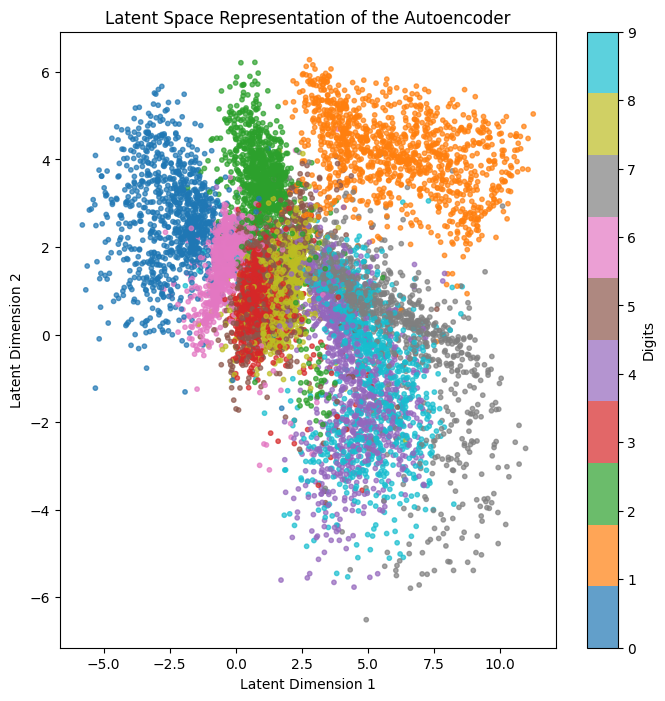

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#Plot latent space
def plot_latent_space(model, data_loader, num_batches=None):
    model.eval()

    all_latents = []
    all_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            #Encode the images into the latent space
            latents = model.encoder(images)
            all_latents.append(latents.cpu().numpy())
            all_labels.append(labels.cpu().numpy())    #keep track of labels

            if num_batches is not None and i >= num_batches - 1:
                break  #Stop after processing the specified number of batches

    #Concatenate all latent representations and labels
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    #Plot scatter plot
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(10), label="Digits")
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Representation of the Autoencoder')
    plt.show()

plot_latent_space(model, test_loader, num_batches=len(test_loader))